# LSTM with Aspect Embedding

В этом ноутбуке мы исследуем применение модели LSTM with Aspect Embedding (AE-LSTM) для решения задачи аспектного анализа тональности. В качестве основы мы берем [статью](https://www.aclweb.org/anthology/D16-1058.pdf).

In [0]:
#!pip install deeppavlov

In [0]:
import os
import zipfile
import random

import pandas as pd
import numpy as np
import torch
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import bs4

from tqdm.notebook import tqdm
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                             recall_score)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from google.colab import drive

USE_GOOGLE_DRIVE = True

sns.set(font_scale=1.2)

Примонтируем наш гугл-диск, если мы решили его использовать.

In [4]:
if USE_GOOGLE_DRIVE:
    drive.mount('/content/drive')
    PATH_PREFIX = 'drive/My Drive/NLP/dialog-sent'
else:
    PATH_PREFIX = '..'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DATA_PREFIX = os.path.join(PATH_PREFIX, 'data')
MODEL_PREFIX = os.path.join(PATH_PREFIX, 'models')

Зададим девайс для обучения.

In [6]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


Проинициализируем везде генераторы случайных чисел.

In [0]:
random_seed = 42
random_state = random_seed

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.determenistic = True
    torch.backends.cudnn.benchmark = False
    if cuda:
        torch.cuda.manual_seed_all(seed)

set_seed_everywhere(random_seed, USE_GPU)

## Повторение результатов статьи

Для того, чтобы применить модель к нашей конкретной задаче для начала надо повторить результаты исследуемой статьи. Будем это делать на примере датасета с [отзывами на рестораны](http://alt.qcri.org/semeval2014/task4/index.php?id=data-and-tools).


### GloVe

В статье используются GloVe-векторы. Вместо использованной в статье версии, натренированной на 840B токенах будем использовать ту, что натренирована на Википедии -- она меньше весит.

Скачаем GloVe (если его у вас нет).

In [0]:
# !mkdir downloads
# !wget http://nlp.stanford.edu/data/glove.6B.zip -P downloads

Распакуем его по нужному пути.

In [0]:
# zip_ref = zipfile.ZipFile('downloads/glove.6B.zip', 'r')
# zip_ref.extractall(os.path.join(DATA_PREFIX, 'raw'))
# zip_ref.close()

Загрузим GloVe векторы в gensim для будущей инициализации модели.

In [229]:
glove_path = os.path.join(DATA_PREFIX, 'raw', 'glove.6B.300d.txt')
word2vec_path = os.path.join(DATA_PREFIX, 'processed', 
                             'glove_word2vecformat.txt')
gensim.scripts.glove2word2vec.glove2word2vec(glove_path, word2vec_path)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(400000, 300)

In [232]:
model_glove = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Данные

Теперь надо разобраться с данными. Мы используем отзывы о рестранах. Согласно аннотации к датасету используются следующие аспекты:

* food
* price
* service
* ambience
* anecdotes (sentences describing the reviewer’s personal experience or context, but that do not usually provide information on the restaurant quality e.g. “I knew upon visiting
NYC that I wanted to try an original deli”)
* miscellaneous (sentences that do not belong to the other five categories including sentences that are general recommendations e.g. “Your friends will thank you for introducing them to this gem!”)

Эта же аннотация говорит о том, какие существуют тональности:
* positive
* negative
* conflict (both positive and negative sentiment)
* neutral (neither positive nor negative sentiment)

Помимо этого существует такой объект, как термин аспекта (aspect term) -- это какое-то слово или выражение, которое указывает на то, в каком слове выражается тональность к конкретному аспекту. 

Существует два вида задач для аспектного анализа тональности:
* Aspect-level Classification -- определить тональность для каждого аспекта.
* Aspect-Term-level Classification -- определить термины для каждого аспекта, а затем определить их тональность.

Наша финальная задача относится к первой категории, а значит нам не нужны данные о терминах аспекта.

Данные предоставлены в формате xml. Для работы с ними будем использовать beautiful soup.

In [0]:
dataset_path = os.path.join(
    DATA_PREFIX, 'raw', "SemEval'14-ABSA-TrainData_v2 & AnnotationGuidelines", 
    'Restaurants_Train_v2.xml'
)

aspect_categories = ['food', 'price', 'service', 'ambience', 
                     'anecdotes/miscellaneous']
num_aspects = len(aspect_categories)
data_dict = {'sentence_id': [], 'text': []}
data_dict.update({key: [] for key in aspect_categories})

sent2class = {'none': 0, 'neutral': 1, 'positive': 2, 'negative': 3, 
              'conflict': 4}

with open(dataset_path, 'r') as inf:
    contents = inf.read()
    soup = bs4.BeautifulSoup(contents, 'xml')
    for sentence in soup.find_all('sentence'):
        data_dict['sentence_id'].append(sentence['id'])

        text = sentence.find('text').text
        data_dict['text'].append(text)

        categories = sentence.find('aspectCategories').find_all(
            'aspectCategory'
        )
        for aspect_category in aspect_categories:
            data_dict[aspect_category].append(0)
        
        for aspect_category in categories:
            data_dict[
                aspect_category['category']
            ][-1] = sent2class[aspect_category['polarity']]

data = pd.DataFrame(data_dict)

In [9]:
data.head()

,sentence_id,text,food,price,service,ambience,anecdotes/miscellaneous
0,3121,But the staff was so horrible to us.,0,0,3,0,0
1,2777,"To be completely fair, the only redeeming fact...",2,0,0,0,3
2,1634,"The food is uniformly exceptional, with a very...",2,0,0,0,0
3,2534,Where Gabriela personaly greets you and recomm...,0,0,2,0,0
4,583,"For those that go once and don't enjoy it, all...",0,0,0,0,2


#### Устаревшее

Теперь, когда данные собраны надо надо сделать общий словарь, чтобы потом легко можно было сделать токенизацию.

In [0]:
save_load_path = os.path.join(DATA_PREFIX, 'processed', 
                              'vocabulary_restaurants')

TOKEN_BEGIN = '<BEGIN>'
TOKEN_END = '<END>'
TOKEN_PAD = '<PAD>'
TOKEN_UNK = '<UNK>'
special_tokens = (TOKEN_BEGIN, TOKEN_END, TOKEN_PAD)

vocab = SimpleVocabulary(
    special_tokens=special_tokens,
    unk_token=TOKEN_UNK,
    save_path=save_load_path, load_path=save_load_path
)

In [0]:
all_words = []
for text in data.text:
    all_words += list(gensim.utils.tokenize(text.lower()))
vocab.fit(all_words)

Теперь, когда мы смогли построить словарь, надо создать датасеты для обучения и валидации.

In [0]:
class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, vocab, num_aspects, begin_token, end_token):
        self.data = data.iloc[:, 1:].values
        self.vocab = vocab
        self.num_aspects = num_aspects
        self.begin_token = begin_token
        self.end_token = end_token

    def __getitem__(self, index):
        """Возвращает пару (aspect, source, target).
        aspect -- индекс аспекта
        source -- индексы слов предложения
        target -- целевой класс      
        """
        index_sentence = index // self.num_aspects
        aspect_index = index % self.num_aspects
        text = self.data[index_sentence][0].lower()
        sentence = ([self.begin_token] 
                    + list(gensim.utils.tokenize(text)) 
                    + [self.end_token])
        aspect = torch.tensor([aspect_index], dtype=torch.int)
        source = torch.tensor([aspect_index] + self.vocab(sentence), 
                              dtype=torch.int)
        target = torch.tensor([self.data[index_sentence, aspect_index+1]], 
                              dtype=torch.int)
        return (aspect, source, target)

    def __len__(self):
        return len(self.data)

Необходимо также реализовать класс для обработки отступов -- так можно будет лучше работать с батчами.

In [0]:
def pad_tensor(vec, length, dim, pad_symbol):
    """Pads a vector ``vec`` up to length ``length`` 
    along axis ``dim`` with pad symbol ``pad_symbol``.
    """
    dtype = vec.dtype
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.size(dim)
    return torch.cat([vec, torch.ones(*pad_size, dtype=dtype)*pad_symbol], 
                     dim=dim)

class Padder:

    def __init__(self, dim=0, pad_symbol=0):
        self.dim = dim
        self.pad_symbol = pad_symbol
        
    def __call__(self, batch):
        # внутри всего батча найдем самую длинную последовательность
        max_len = max(map(lambda x: x[1].shape[self.dim], batch))
        # выполним отступ для всего батча
        new_batch = [
                     (pad_tensor(x[0], max_len, self.dim, self.pad_symbol),
                      pad_tensor(x[1], max_len, self.dim, self.pad_symbol),
                      pad_tensor(x[2], max_len, self.dim, self.pad_symbol))
                     for x in batch
        ]
        # собираем аспекты, обучение и таргет
        aspects_list = [x[0] for x in new_batch]
        xs_list = [x[1] for x in new_batch]
        ys_list = [x[2] for x in new_batch]
        aspects_list = torch.stack(aspects_list, dim=0)
        xs = torch.stack(xs_list, dim=0)
        ys = torch.stack(ys_list, dim=0)
        return aspects_list, xs, ys



Посмотрим, что выдает такой датасет.

In [0]:
train, validate = train_test_split(data, random_state=random_state)
train_dataset = Dataset(train, vocab, num_aspects, TOKEN_BEGIN, TOKEN_END)
validate_dataset = Dataset(validate, vocab, num_aspects, TOKEN_BEGIN, TOKEN_END)

In [238]:
dataloader_train = DataLoader(train_dataset, batch_size=5, 
                              shuffle=True, num_workers=4, 
                              collate_fn=Padder(
                                  dim=0, pad_symbol=vocab(TOKEN_PAD))
                              )

for i_batch, (aspect_batched, sample_batched, target_batched) in enumerate(dataloader_train):
    if i_batch == 10:
        break
    print(target_batched.size())

torch.Size([5, 20])
torch.Size([5, 20])
torch.Size([5, 28])
torch.Size([5, 22])
torch.Size([5, 23])
torch.Size([5, 31])
torch.Size([5, 36])
torch.Size([5, 14])
torch.Size([5, 21])
torch.Size([5, 17])


#### Новое

Чтобы правильно обучать нашу модель придется упростить данные до трех столбцов: `text`, `aspect`, `sentiment`.

In [10]:
data_to_train_dict = {'text': [], 'aspect': [], 'sentiment': []}
for i, row in data.iterrows():
    for aspect_category in aspect_categories:
        data_to_train_dict['text'].append(row['text'])
        data_to_train_dict['aspect'].append(aspect_category)
        data_to_train_dict['sentiment'].append(row[aspect_category])

data_to_train = pd.DataFrame(data_to_train_dict)
data_path = os.path.join(DATA_PREFIX, 'processed', 'restaurants.csv')
data_to_train.to_csv(data_path, index=False)
data_to_train.head(10)

,text,aspect,sentiment
0,But the staff was so horrible to us.,food,0
1,But the staff was so horrible to us.,price,0
2,But the staff was so horrible to us.,service,3
3,But the staff was so horrible to us.,ambience,0
4,But the staff was so horrible to us.,anecdotes/miscellaneous,0
5,"To be completely fair, the only redeeming fact...",food,2
6,"To be completely fair, the only redeeming fact...",price,0
7,"To be completely fair, the only redeeming fact...",service,0
8,"To be completely fair, the only redeeming fact...",ambience,0
9,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,3


Теперь определим поля в датасете для обучения.

In [0]:
TEXT = torchtext.data.Field(
    tokenize='spacy', batch_first=True, init_token='<begin>', 
    eos_token='<end>', lower=True
)
ASPECT = torchtext.data.Field(sequential=False, batch_first=True)
SENTIMENT = torchtext.data.LabelField(batch_first=True)

In [0]:
fields = [('text', TEXT), ('aspect', ASPECT), ('sentiment', SENTIMENT)]

In [13]:
training_data = torchtext.data.TabularDataset(
    path=data_path, format = 'csv', fields=fields, skip_header=True
)

print(vars(training_data.examples[0]))

{'text': ['but', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us', '.'], 'aspect': 'food', 'sentiment': '0'}


Разделим данные на валидацию и тест.

In [0]:
train_data, valid_data = training_data.split(
    split_ratio=0.75, random_state=random.seed(random_state)
)

Построим для нашего датасета словарь. Согласно статье, эмбеддинги слов были проинициализированы при помощи GloVe, а для неизвестных слов в качестве эмбеддингов были взяты случайные векторы из $U(-\varepsilon, \varepsilon)$, где $\varepsilon = 0.01$.


In [15]:
epsilon = 0.01
TEXT.build_vocab(train_data, vectors='glove.6B.300d', 
                 unk_init=lambda x: torch.nn.init.uniform_(x, -epsilon, epsilon))
ASPECT.build_vocab(train_data) 
SENTIMENT.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                          
100%|█████████▉| 399125/400000 [00:39<00:00, 10235.75it/s]

In [16]:
print(f'Size of TEXT vocabulary: {len(TEXT.vocab)}')
print(f'Size of ASPECT vocabulary: {len(ASPECT.vocab)}')
print(f'Size of SENTIMENT vocabulary: {len(SENTIMENT.vocab)}')

Size of TEXT vocabulary: 4493
Size of ASPECT vocabulary: 6
Size of SENTIMENT vocabulary: 5


Теперь напишем итератор.

In [0]:
batch_size = 25

train_iter, val_iter = torchtext.data.BucketIterator.splits(
        (train_data, valid_data),
        batch_sizes=(batch_size, batch_size),
        sort=True,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device,
        repeat=False
)

### Модель

Зададим архитектуру нашей сети.

In [0]:
class AE_LSTM(nn.Module):

    def __init__(
        self, num_aspects, embeddings_aspects_dim, hidden_dim, 
        num_sentiments, 
        vocab_size=None, embeddings_words_dim=None, embeddings_words_init=None
    ):
        super(AE_LSTM, self).__init__()

        train_from_scratch = (vocab_size is not None 
                              and embedding_words_dim is not None)
        use_pretrained = embeddings_words_init is not None
        if not(train_from_scratch or use_pretrained):
            raise ValueError('You should use pretrained vectors or '
                             'set vocab size and embeddings dim')

        if train_from_scratch:
            self.embeddings_words = nn.Embedding(
                vocab_size, embeddings_words_dim
            )
        else:
            self.embeddings_words = nn.Embedding.from_pretrained(
                embeddings_words_init
            )
            vocab_size, embeddings_words_dim = embeddings_words_init.size()

        self.embeddings_aspects = nn.Embedding(
            num_aspects, embeddings_aspects_dim
        )
        self.lstm = nn.LSTM(
            embeddings_aspects_dim + embeddings_words_dim, 
            hidden_dim, batch_first=True
        )
        self.hidden_to_sentiments = nn.Linear(hidden_dim, num_sentiments)

        # weights initializatioin
        torch.nn.init.xavier_uniform_(self.embeddings_aspects.weight)
        torch.nn.init.xavier_uniform_(self.hidden_to_sentiments.weight)
        
    def forward(self, texts, aspects, hidden=None):
        batch_size, seq_len = texts.size()
        # shape: [batch_size, seq_len] -> [batch_size, seq_len, embeddings_words_dim]
        embeddings_words_out = self.embeddings_words(texts)
        # shape: [batch_size] -> [batch_size, seq_len, embedding_aspects_dim]
        embeddings_aspects_out = self.embeddings_aspects(aspects)
        embeddings_aspects_out = torch.unsqueeze(embeddings_aspects_out, 1)
        embeddings_aspects_out = torch.repeat_interleave(
            embeddings_aspects_out, seq_len, 1
        )
        # shape: -> [batch_size, seq_len, embedding_words_dim + embedding_aspects_dim]
        embeddings = torch.cat(
            [embeddings_words_out, embeddings_aspects_out], dim=-1,
        )
        # shape: [batch_size, seq_len, embeddings_dim] -> [batch_size, hidden_dim]
        lstm_out, hidden_state = self.lstm(embeddings, hidden)
        lstm_out = lstm_out[:, -1, :]
        # shape: [batch_size, hidden_size] -> [batch_size, num_sentiments]
        sentiments_scores = self.hidden_to_sentiments(lstm_out)
        return sentiments_scores, hidden_state

Возьмем параметры, как в статье: `embeddings_aspects_dim=300`, `hidden_dim=300`.

In [47]:
num_aspects = len(ASPECT.vocab)
embeddings_aspects_dim = 300
hidden_dim = 300
num_sentiments = len(SENTIMENT.vocab)
embeddings_words_init = TEXT.vocab.vectors
model = AE_LSTM(
    num_aspects, embeddings_aspects_dim, hidden_dim, num_sentiments, 
    embeddings_words_init=embeddings_words_init
)
model

AE_LSTM(
  (embeddings_words): Embedding(4493, 300)
  (embeddings_aspects): Embedding(6, 300)
  (lstm): LSTM(600, 300, batch_first=True)
  (hidden_to_sentiments): Linear(in_features=300, out_features=5, bias=True)
)

### Тренировочный цикл

Здесь мы реализуем тренировочный цикл для нашей модели. К сожалению, установить momentum, как в статье не удалось (там почему-то написано, что они установили его для Adagrad).

In [0]:
model = model.to(device=device)
learning_rate = 1e-3
early_stopping = 10
epochs = 30

opt = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
criterion = nn.CrossEntropyLoss()
path_save = os.path.join(MODEL_PREFIX, 'ae_lstm', 'ae_lstm.pt')

In [49]:
set_seed_everywhere(random_seed, USE_GPU)
epoch_losses = []
val_losses = []
best_val_loss = 10
not_improves = 0
for epoch in tqdm(range(1, epochs + 1)):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for batch in train_iter: 

        texts = batch.text.to(device=device)
        aspects = batch.aspect.to(device=device)
        sentiments = batch.sentiment.to(device=device)

        opt.zero_grad()
        preds, _ = model(texts, aspects)
        loss = criterion(preds, sentiments)
        loss.backward()
        opt.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_data)
    epoch_losses.append(epoch_loss)

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in val_iter:

            texts = batch.text.to(device=device)
            aspects = batch.aspect.to(device=device)
            sentiments = batch.sentiment.to(device=device)

            preds, _ = model(texts, aspects)   
            loss = criterion(preds, sentiments)
            val_loss += loss.item()

    val_loss /= len(valid_data)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        not_improves = 0
        best_val_loss = val_loss
        torch.save(model.state_dict(), path_save)
    else:
        not_improves += 1
        if not_improves == early_stopping:
            break
    
    scheduler.step()

    print(f'Epoch: {epoch}, Training Loss*: {1000*epoch_loss:.5f}, '
          f'Validation Loss*: {1000*val_loss:.5f}')

Epoch: 1, Training Loss*: 26.83320, Validation Loss*: 28.64953
Epoch: 2, Training Loss*: 19.12386, Validation Loss*: 21.03081
Epoch: 3, Training Loss*: 14.78698, Validation Loss*: 19.07284
Epoch: 4, Training Loss*: 12.12207, Validation Loss*: 18.70477
Epoch: 5, Training Loss*: 9.22289, Validation Loss*: 17.70138
Epoch: 6, Training Loss*: 7.57758, Validation Loss*: 18.59311
Epoch: 7, Training Loss*: 6.58980, Validation Loss*: 19.62089
Epoch: 8, Training Loss*: 5.71753, Validation Loss*: 21.01518
Epoch: 9, Training Loss*: 4.91448, Validation Loss*: 21.41659
Epoch: 10, Training Loss*: 4.72656, Validation Loss*: 21.76097
Epoch: 11, Training Loss*: 4.61104, Validation Loss*: 22.04983
Epoch: 12, Training Loss*: 4.51003, Validation Loss*: 22.30710
Epoch: 13, Training Loss*: 4.40572, Validation Loss*: 22.33826
Epoch: 14, Training Loss*: 4.39550, Validation Loss*: 22.36877


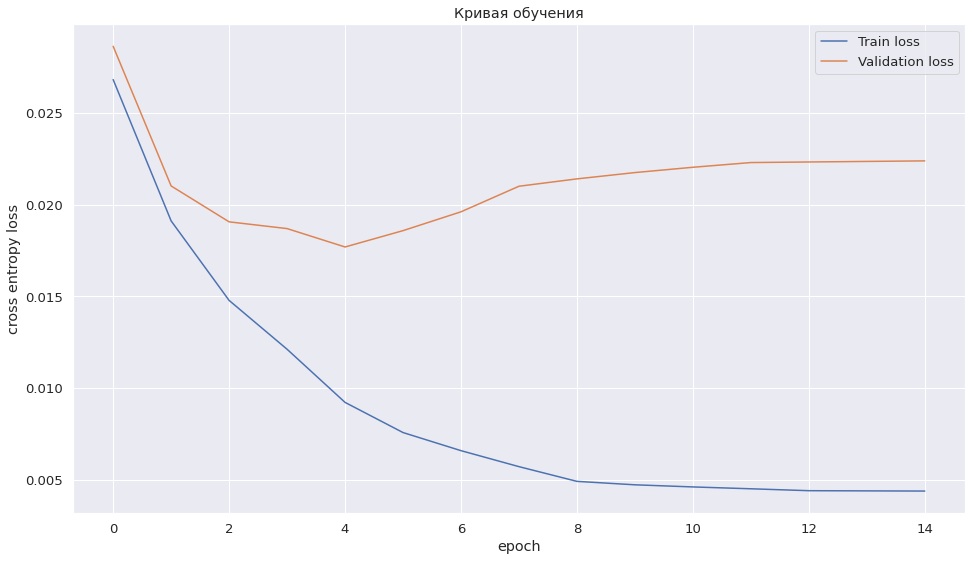

In [52]:
plt.figure(figsize=(16, 9))
finished_epochs = len(epoch_losses)
plt.plot(np.arange(finished_epochs), epoch_losses, label='Train loss')
plt.plot(np.arange(finished_epochs), val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Кривая обучения')
plt.legend()
plt.show()

Измерим качество полученной модели.

In [53]:
model.load_state_dict(torch.load(path_save))

<All keys matched successfully>

In [0]:
model.eval()

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in val_iter:

        texts = batch.text.to(device=device)
        aspects = batch.aspect.to(device=device)
        sentiments = batch.sentiment.to(device=device)

        preds_scores, _ = model(texts, aspects)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()

all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [81]:
accuracy = accuracy_score(all_preds, all_answers)

print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.861
